# 0 - Introduccion

Primero vamos a cargar todas las librerias. Tanto más generales, como numpy y pandas, como aquellas relativas a deep learning (Tensorflow, Keras..)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Nos aseguramos que scikit learn este actualizado a la última versión, ya que sino, el código no funciona

In [ ]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 1.5MB/s 


In [ ]:
!unzip drive/MyDrive/Colab_Notebooks/Proyecto_DL/Pictures.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: content/Pictures/image-08724.jpg  
  inflating: content/Pictures/image-07243.jpg  
  inflating: content/Pictures/image-04800.jpg  
  inflating: content/Pictures/image-14444.jpg  
  inflating: content/Pictures/image-14683.jpg  
  inflating: content/Pictures/image-10671.jpg  
  inflating: content/Pictures/image-14148.jpg  
  inflating: content/Pictures/image-10540.jpg  
  inflating: content/Pictures/image-13173.jpg  
  inflating: content/Pictures/image-06366.jpg  
  inflating: content/Pictures/image-01292.jpg  
  inflating: content/Pictures/image-01369.jpg  
  inflating: content/Pictures/image-03685.jpg  
  inflating: content/Pictures/image-05846.jpg  
  inflating: content/Pictures/image-06191.jpg  
  inflating: content/Pictures/image-14711.jpg  
  inflating: content/Pictures/image-00158.jpg  
  inflating: content/Pictures/image-09147.jpg  
  inflating: content/Pictures/image-12361.jpg  
  inflating: content/Pictur

In [ ]:
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import pandas as pd
%matplotlib inline

import sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras import layers, Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model
#from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

np.random.seed(1)

Nos aseguramos la reproducibilidad de los modelos fijando "seeds"

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

Ahora procedemos a cargar el dataset de airbnb

In [ ]:
df_full = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Proyecto_DL/airbnb-listings.csv', sep=';',decimal='.')
len(df_full)

14780

Este es el script que se utilizo para descargar las imagenes de cada airbnb

In [ ]:
#import urllib.request
#images = []
#for i in range(len (df_full)): #df_full es el dataset tal y como esta nada mas cargarlo del csv
#    print(i)
#    try:
#        image = urllib.request.urlretrieve(df_full["Thumbnail Url"][i], "Pictures/image-{}.jpg".format(str(i).zfill(5))) 
        # Explicación de la función urllib.request.urlretrieve 
        # El primer atributo(df_full["Thumbnail Url"][i]) indica de donde leemos la Url
        # El segundo atributo ("Pictures/image-{}.jpg".format(str(i).zfill(5))), indica donde guardamos la imagen 
        #y bajo que nombre
#        images.append(image)
#    except:
#        continue    

Eliminamos todas las filas que no tienen una imagen asociada y creaamos el dataframe con los datos numericos y categoricos, y el array con las imagenes. Los indices del array concuerdan con los indices del dataframe, de tal forma que sabemos la correspondencia entre el dataframe y el array de imagenes

In [ ]:
import os.path
import cv2
images=[]
delete=[]

for i in range(len(df_full)):
    if os.path.isfile ("content/Pictures/image-{}.jpg".format(str(i).zfill(5))) :
        housePath = "content/Pictures/image-{}.jpg".format(str(i).zfill(5))
        image = cv2.imread(housePath)
        image = cv2.resize(image, (108, 72))
        #108, 72
        images.append(image)
    else:
        delete.append(i)

df_full = df_full.drop(delete).reset_index(drop=True)
images = np.array(images)


Tomamos solo Madrid para reducir el valor del dataset y que así sea más facil tratar los datos.

In [ ]:
df_full = df_full[df_full["City"] == "Madrid"]
len(df_full)

10702

Hacemos division entre test y train (solo se realiza para el dataframe, pero al estar relacionados por los indices, luego no sera dificil aplicarlo tambien al array de imagenes)

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test= train_test_split(df_full, test_size=0.2, shuffle=True, random_state=0)

Tomamos solo Madrid para reducir el valor del dataset y que así sea más facil tratar los datos.

# **1- Procesado de datos antes de la introducción al modelo**

Primero vamos a ver las caracteristicas que tenemos


In [ ]:
df_train.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

Eliminamos todas aquellas caracteristicas que tienen mas de un 70% de NA's

In [ ]:
delete = (df_train.isnull().sum()> round(0.7*df_train.shape[0]))[(df_train.isnull().sum()> round(0.7*df_train.shape[0]))[:] ==True]
delete = delete.axes[0].tolist()
print(f"Las columnas eliminadas son {delete}")
print(f"En valor absoluto hemos quitado {len(delete)} columnas de {df_train.shape[1]} quedando asi {df_train.shape[1]-len(delete)}")
print(f"En valor relativo hemos quitado un {round((len(delete))*100/df_train.shape[1],2)} % de las columnas")
df_train = df_train.drop(columns=delete)

Las columnas eliminadas son ['Host Acceptance Rate', 'Square Feet', 'Weekly Price', 'Monthly Price', 'Has Availability', 'License', 'Jurisdiction Names']
En valor absoluto hemos quitado 7 columnas de 89 quedando asi 82
En valor relativo hemos quitado un 7.87 % de las columnas


Repetimos operacion para el df_test

In [ ]:
df_test = df_test.drop(columns=delete)

# 1.1 - Preprocesado de columnas no-numericas (object)

Empezamos por aquellas que contengan texto que no pueda ser codificado.

In [ ]:
df_train.select_dtypes(['object']).head()

,Listing Url,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Property Type,Room Type,Bed Type,Amenities,Calendar Updated,Calendar last Scraped,First Review,Last Review,Cancellation Policy,Geolocation,Features
4068,https://www.airbnb.com/rooms/7013484,2017-04-08,Apartment in Sol ; Check in 24h.,You can pick up the keys the 24 hours. It´s po...,"Cozy apartment in the center of Madrid, 2 minu...",You can pick up the keys the 24 hours. It´s po...,none,The apartment is placed on the neighbourhood o...,"It features one double bed, one single bed, on...",The apartment is placed in the best-communicat...,Se ofrece la posibilidad de guardar el equipaj...,The guests can ask for any turistic informatio...,- It´s forbidden to make partys or noise after...,https://a0.muscache.com/im/pictures/f5073380-1...,https://a0.muscache.com/im/pictures/f5073380-1...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/f5073380-1...,https://www.airbnb.com/users/show/36767873,Helios,2015-06-26,"Madrid, Community of Madrid, Spain","Persona activa, extrovertida y con ganas de em...",within an hour,https://a0.muscache.com/im/pictures/8915fa97-5...,https://a0.muscache.com/im/pictures/8915fa97-5...,Cortes,"email,phone,reviews,jumio","Cortes, Madrid, Comunidad de Madrid 28012, Spain",Cortes,Cortes,Centro,Madrid,Comunidad de Madrid,28012,Madrid,"Madrid, Spain",ES,Spain,Apartment,Entire home/apt,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",today,2017-04-07,2015-07-08,2017-03-25,moderate,"40.4152887781,-3.70166427102","Host Has Profile Pic,Host Identity Verified,Is..."
10882,https://www.airbnb.com/rooms/6697112,2017-04-08,"Center, Fresh, Quiet, Clean & Comfy Beds#1","Affordable Madrid, Oh yes you can! The mattres...","Just the right size of the room, as all in the...","Affordable Madrid, Oh yes you can! The mattres...",none,The neighborhood The location is perfect for ...,Minimum stay of 2 nights. If for any reason yo...,How to get around There are 4 Metro lines ava...,SERVICES AND COMMUNAL AREAS Communal areas co...,For the attention of the guests We will be ve...,HOUSE DOOR HAS TO BE LOCKED WITH THE KEY ALWAY...,https://a0.muscache.com/im/pictures/86884269/3...,https://a0.muscache.com/im/pictures/86884269/3...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/86884269/3...,https://www.airbnb.com/users/show/35055507,Maria Luisa,2015-06-05,"Madrid, Community of Madrid, Spain","Hello, We are María, Marta and Luisa! \r\n \r\...",within an hour,https://a0.muscache.com/im/pictures/765bc657-d...,https://a0.muscache.com/im/pictures/765bc657-d...,Gaztambide,"email,phone,reviews,jumio","Gaztambide, Madrid, Comunidad de Madrid 28015,...",Gaztambide,Gaztambide,Chamberí,Madrid,Comunidad de Madrid,28015,Madrid,"Madrid, Spain",ES,Spain,Apartment,Private room,Real Bed,"TV,Wireless Internet,Air conditioning,Doorman,...",3 days ago,2017-04-07,2015-06-28,2017-03-25,moderate,"40.4348647146,-3.7173042005","Host Is Superhost,Host Has Profile Pic,Host Id..."
586,https://www.airbnb.com/rooms/15015080,2017-04-08,Hab. c/2 camas singles y balcón en plena Gran Vía,Habitación privada con 2 camas single y balcón...,"Hermoso, enorme y elegante piso sobre calle Gr...",Habitación privada con 2 camas single y balcón...,none,La Gran Vía es uno de los centros neurálgicos ...,NaN,Localización: 200 metros al norte de Puerta de...,Los huéspedes tendrán acceso a cualquiera de l...,Estaremos disponibles y atentos a las necesida...,"- Respeto por la propiedad, los huéspedes y lo...",https://a0.muscache.com/i

Para ello vamos a eliminar todas las columnas que tengan alguna entrada mayor a 50 caracteres ya que por ahora no vamos a plicar NLP

In [ ]:
delete = df_train.select_dtypes(['object']).applymap(lambda x: len(str(x)) > 50).any(axis=0)
delete = delete[delete[:]==True]
delete = delete.axes[0].tolist()
print(f"Las columnas eliminadas son {delete}")
print(f"En valor absoluto hemos quitado {len(delete)} columnas de {df_train.shape[1]} quedando asi {df_train.shape[1]-len(delete)}")
print(f"En valor relativo hemos quitado un {round((len(delete))*100/df_train.shape[1],2)} % de las columnas")

df_train = df_train.drop(columns=delete)

Las columnas eliminadas son ['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host Location', 'Host About', 'Host Thumbnail Url', 'Host Picture Url', 'Host Verifications', 'Street', 'Amenities', 'Features']
En valor absoluto hemos quitado 22 columnas de 82 quedando asi 60
En valor relativo hemos quitado un 26.83 % de las columnas


Repetimos operacion para el df_test

In [ ]:
df_test = df_test.drop(columns=delete)

Vamos a ver que columnas de tipo object quedan en el modelo

In [ ]:
df_train.select_dtypes(['object']).columns

Index(['Listing Url', 'Last Scraped', 'Experiences Offered', 'Host URL',
       'Host Name', 'Host Since', 'Host Response Time', 'Host Neighbourhood',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Property Type',
       'Room Type', 'Bed Type', 'Calendar Updated', 'Calendar last Scraped',
       'First Review', 'Last Review', 'Cancellation Policy', 'Geolocation'],
      dtype='object')

In [ ]:
df_train.select_dtypes(['object']).nunique()

Listing Url                     8561
Last Scraped                       1
Experiences Offered                1
Host URL                        5716
Host Name                       2316
Host Since                      1885
Host Response Time                 4
Host Neighbourhood               103
Neighbourhood                     65
Neighbourhood Cleansed           125
Neighbourhood Group Cleansed      21
City                               1
State                             13
Zipcode                           70
Market                             2
Smart Location                     2
Country Code                       1
Country                            1
Property Type                     21
Room Type                          3
Bed Type                           5
Calendar Updated                  52
Calendar last Scraped              2
First Review                    1387
Last Review                      540
Cancellation Policy                5
Geolocation                     8561
d

Procedemos a borrar aquellas que no interesan para el modelo

In [ ]:
delete = ["Listing Url","Host URL", "Host Name", "Smart Location", "Geolocation"]

print(f"Las columnas eliminadas son {delete}")
print(f"En valor absoluto hemos quitado {len(delete)} columnas de {df_train.shape[1]} quedando asi {df_train.shape[1]-len(delete)}")
print(f"En valor relativo hemos quitado un {round((len(delete))*100/df_train.shape[1],2)} % de las columnas")

df_train= df_train.drop(columns=delete)

Las columnas eliminadas son ['Listing Url', 'Host URL', 'Host Name', 'Smart Location', 'Geolocation']
En valor absoluto hemos quitado 5 columnas de 60 quedando asi 55
En valor relativo hemos quitado un 8.33 % de las columnas


Repetimos operacion para el df_test

In [ ]:
df_test = df_test.drop(columns=delete)

Vamos a borrar tambien todas las fechas (de momento)

In [ ]:
delete = ["Last Scraped", "Host Since", "Calendar Updated", "Calendar last Scraped", "First Review", "Last Review"]
print(f"Las columnas eliminadas son {delete}")
print(f"En valor absoluto hemos quitado {len(delete)} columnas de {df_train.shape[1]} quedando asi {df_train.shape[1]-len(delete)}")
print(f"En valor relativo hemos quitado un {round((len(delete))*100/df_train.shape[1],2)} % de las columnas")

df_train= df_train.drop(columns=delete)
#El script de abajo es para transformar la fecha a años, no funciona porque tenemos NA's
#from datetime import datetime
#df_train["Host Since"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d").strftime("%Y"))


Las columnas eliminadas son ['Last Scraped', 'Host Since', 'Calendar Updated', 'Calendar last Scraped', 'First Review', 'Last Review']
En valor absoluto hemos quitado 6 columnas de 55 quedando asi 49
En valor relativo hemos quitado un 10.91 % de las columnas


Repetimo operacion para el df_test

In [ ]:
df_test= df_test.drop(columns=delete)

Nos deshacemos de "Country Code", "Country, y "City" ya que hems restringido el dataset a Madrid

In [ ]:
delete = ["Country Code", "Country", "City"]
print(f"Las columnas eliminadas son {delete}")
print(f"En valor absoluto hemos quitado {len(delete)} columnas de {df_train.shape[1]} quedando asi {df_train.shape[1]-len(delete)}")
print(f"En valor relativo hemos quitado un {round((len(delete))*100/df_train.shape[1],2)} % de las columnas")

df_train= df_train.drop(columns=delete)

Las columnas eliminadas son ['Country Code', 'Country', 'City']
En valor absoluto hemos quitado 3 columnas de 49 quedando asi 46
En valor relativo hemos quitado un 6.12 % de las columnas


Hacemos lo propio en test

In [ ]:
df_test= df_test.drop(columns=delete)

Vamos a proceder a codificar y a tratar con los valores Na de las caracteristicas de tipo object que aun forman parte del modelo

In [ ]:
df_train.select_dtypes(['object']).nunique()

Experiences Offered               1
Host Response Time                4
Host Neighbourhood              103
Neighbourhood                    65
Neighbourhood Cleansed          125
Neighbourhood Group Cleansed     21
State                            13
Zipcode                          70
Market                            2
Property Type                    21
Room Type                         3
Bed Type                          5
Cancellation Policy               5
dtype: int64

In [ ]:
#Vamos a realizar "target encoding" para dar valor a las variables de tipo object
means_1 = df_train.groupby('Cancellation Policy')['Price'].mean()
means_2 = df_train.groupby('Bed Type')['Price'].mean()
means_3 = df_train.groupby('Room Type')['Price'].mean()
means_4 = df_train.groupby('Property Type')['Price'].mean()


means_7 = df_train.groupby('Market')['Price'].mean()
means_8 = df_train.groupby('Zipcode')['Price'].mean()
means_9 = df_train.groupby('State')['Price'].mean()
means_10 = df_train.groupby('Neighbourhood Cleansed')['Price'].mean()
means_11 = df_train.groupby('Neighbourhood Group Cleansed')['Price'].mean()
means_12 = df_train.groupby('Host Neighbourhood')['Price'].mean()
means_13 = df_train.groupby('Neighbourhood')['Price'].mean()
means_14 = df_train.groupby('Host Response Time')['Price'].mean()
means_15 = df_train.groupby('Experiences Offered')['Price'].mean()


#Sustituimos los caracteres por los valores de la media
df_train['Cancellation Policy'] = df_train['Cancellation Policy'].map(means_1)
df_train['Bed Type'] = df_train['Bed Type'].map(means_2)
df_train['Room Type'] = df_train['Room Type'].map(means_3)
df_train['Property Type'] = df_train['Property Type'].map(means_4)


df_train['Market'] = df_train['Market'].map(means_7)
df_train['Zipcode'] = df_train['Zipcode'].map(means_8)
df_train['State'] = df_train['State'].map(means_9)
df_train['Neighbourhood Cleansed'] = df_train['Neighbourhood Cleansed'].map(means_10)
df_train['Neighbourhood Group Cleansed'] = df_train['Neighbourhood Group Cleansed'].map(means_11)
df_train['Host Neighbourhood'] = df_train['Host Neighbourhood'].map(means_12)
df_train['Neighbourhood'] = df_train['Neighbourhood'].map(means_13)
df_train['Host Response Time'] = df_train['Host Response Time'].map(means_14)
df_train['Experiences Offered'] = df_train['Experiences Offered'].map(means_15)



Repetimos operacion para el df_test

In [ ]:
df_test['Cancellation Policy'] = df_test['Cancellation Policy'].map(means_1)
df_test['Bed Type'] = df_test['Bed Type'].map(means_2)
df_test['Room Type'] = df_test['Room Type'].map(means_3)
df_test['Property Type'] = df_test['Property Type'].map(means_4)


df_test['Market'] = df_test['Market'].map(means_7)
df_test['Zipcode'] = df_test['Zipcode'].map(means_8)
df_test['State'] = df_test['State'].map(means_9)
df_test['Neighbourhood Cleansed'] = df_test['Neighbourhood Cleansed'].map(means_10)
df_test['Neighbourhood Group Cleansed'] = df_test['Neighbourhood Group Cleansed'].map(means_11)
df_test['Host Neighbourhood'] = df_test['Host Neighbourhood'].map(means_12)
df_test['Neighbourhood'] = df_test['Neighbourhood'].map(means_13)
df_test['Host Response Time'] = df_test['Host Response Time'].map(means_14)
df_test['Experiences Offered'] = df_test['Experiences Offered'].map(means_15)


# 1.2 Preprocesado de los datos numericos

Volvemos a mirar las columnas que quedan

In [ ]:
df_train.columns

Index(['ID', 'Scrape ID', 'Experiences Offered', 'Host ID',
       'Host Response Time', 'Host Response Rate', 'Host Neighbourhood',
       'Host Listings Count', 'Host Total Listings Count', 'Neighbourhood',
       'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'State',
       'Zipcode', 'Market', 'Latitude', 'Longitude', 'Property Type',
       'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds',
       'Bed Type', 'Price', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights',
       'Availability 30', 'Availability 60', 'Availability 90',
       'Availability 365', 'Number of Reviews', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'Cancellation Policy',
       'Calculated host listings count', 'Reviews per Month'],
      dtype='object')

Nos deshacemos de aquellas columnas que no esperamos que tengan impacto

In [ ]:
delete = ["ID", "Scrape ID", "Host ID", "Reviews per Month"]
print(f"Las columnas eliminadas son {delete}")
print(f"En valor absoluto hemos quitado {len(delete)} columnas de {df_train.shape[1]} quedando asi {df_train.shape[1]-len(delete)}")
print(f"En valor relativo hemos quitado un {round((len(delete))*100/df_train.shape[1],2)} % de las columnas")
df_train = df_train.drop(columns=delete)

Las columnas eliminadas son ['ID', 'Scrape ID', 'Host ID', 'Reviews per Month']
En valor absoluto hemos quitado 4 columnas de 46 quedando asi 42
En valor relativo hemos quitado un 8.7 % de las columnas


Realizamos la misma operacion para df_test

In [ ]:
df_test = df_test.drop(columns=delete)

Tratamos los valores NA sustituyendolos por valores numéricos más apropiados

In [ ]:
# Algunas caracteristicas podemos asumir que, si tienen valores NA, es porque su valor es cero
df_train["Security Deposit"].fillna(value=0, inplace=True)
df_train["Cleaning Fee"].fillna(value=0, inplace=True)
df_train["Guests Included"].fillna(value=0, inplace=True)
df_train["Extra People"].fillna(value=0, inplace=True)
df_train["Minimum Nights"].fillna(value=0, inplace=True)
# Al resto de valores les daremos el valor de la media
df_train.fillna(df_train.mean()[0], inplace=True)

Realizamos la misma operacion para df_test

In [ ]:
df_test["Security Deposit"].fillna(value=0, inplace=True)
df_test["Cleaning Fee"].fillna(value=0, inplace=True)
df_test["Guests Included"].fillna(value=0, inplace=True)
df_test["Extra People"].fillna(value=0, inplace=True)
df_test["Minimum Nights"].fillna(value=0, inplace=True)
df_test.fillna(df_test.mean()[0], inplace=True)

A continuacion tratamos outliers

In [ ]:
df_train["Price"].describe()

count    8561.000000
mean       61.573449
std        52.737800
min         9.000000
25%        30.000000
50%        50.000000
75%        75.000000
max       850.000000
Name: Price, dtype: float64

In [ ]:
df_train["Price"].value_counts()

50.0     395
25.0     380
30.0     371
20.0     316
60.0     306
        ... 
206.0      1
146.0      1
230.0      1
434.0      1
590.0      1
Name: Price, Length: 241, dtype: int64

(0.0, 1000.0, 0.0, 5000.0)

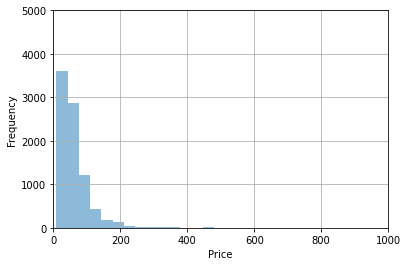

In [ ]:
df_train['Price'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Price')
plt.axis([0, 1000, 0, 5000])

In [ ]:
len(df_train[df_train['Price'] > 200])/len(df_train)

0.017871743955145427

In [ ]:
# Si quitamos todas las filas con valores de price > 200 aun conservamos la mayoria de las filas
df_train = df_train[df_train['Price'] < 200]

Hacemos la misma operacion para df_test

In [ ]:
df_test = df_test[df_test['Price'] < 200]

Por último hacemos el analisis de correlacion

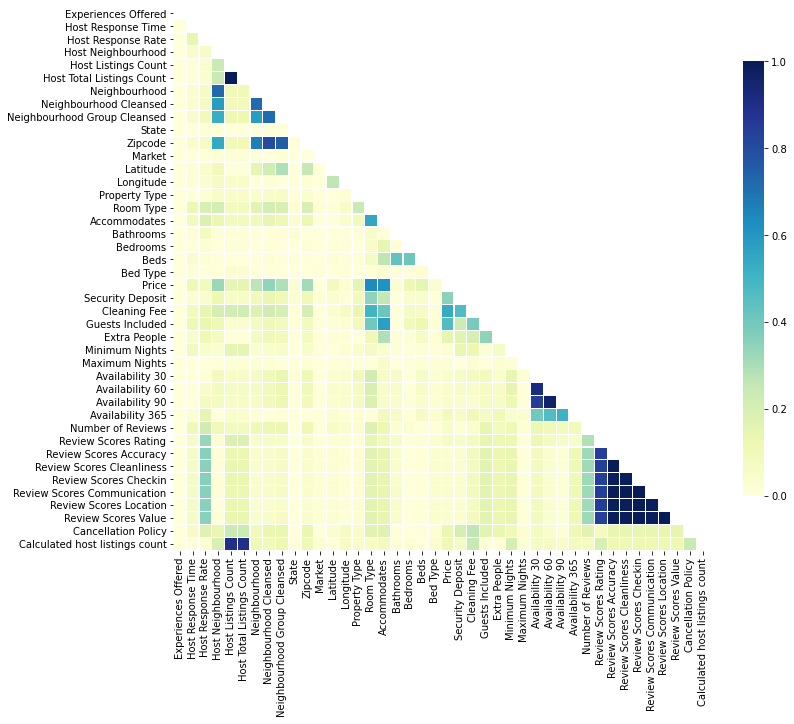

In [ ]:
#Ahora vamos a echar un vistazo a la matriz de correlacion para deshacernos de variables con alta dependencia lineal

import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()


In [ ]:
corr>0.85

,Experiences Offered,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,State,Zipcode,Market,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count
Experiences Offered,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Host Response Time,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Host Response Rate,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Host Neighbourhood,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Host Listings Count,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
Host Total Listings Count,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
Neighbourhood,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Neighbourhood Cleansed,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Neighbourhood Group Cleansed,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
State,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Nos deshacemos de todas las variables que segun el analisis de correlación son redundantes dejando solo una de cada conjunto

In [ ]:
# Nos desacemos de todas aquellas variables que tienen una altacorrelacion entre si y nos quedamos solo con una de cada
size_train = df_train.shape[1]
df_train = df_train.drop(columns=["Neighbourhood Group Cleansed","Review Scores Cleanliness","Review Scores Checkin","Review Scores Accuracy", "Review Scores Location", "Review Scores Communication","Availability 60", "Availability 90", "Calculated host listings count","Host Total Listings Count"])
print(f"En valor absoluto hemos quitado {size_train-df_train.shape[1]} columnas de {size_train} quedando así {df_train.shape[1]} columnas")
print(f"En valor relativo hemos quitado un {round((size_train-df_train.shape[1])*100/size_train,2)} % de las columnas")

En valor absoluto hemos quitado 10 columnas de 42 quedando así 32 columnas
En valor relativo hemos quitado un 23.81 % de las columnas


Hacemos la misma operacion para df_test

In [ ]:
df_test = df_test.drop(columns=["Neighbourhood Group Cleansed","Review Scores Cleanliness","Review Scores Checkin","Review Scores Accuracy", "Review Scores Location", "Review Scores Communication","Availability 60", "Availability 90", "Calculated host listings count","Host Total Listings Count"])

# 1.3 - Tratamiento final de los datos

Normalizamos los inputs numericos, categoricos y de imagenes

In [ ]:
y_train_max = df_train["Price"].max()

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df_train.copy(True).drop(columns="Price"))
train_features = scaler.transform(np.array(df_train.copy(True).drop(columns="Price")))
train_labels = np.array(df_train.copy(True).pop('Price')/y_train_max)

In [ ]:
images= np.asarray(images)/255.0

Dividimos el train en train y validation para poder valorar los modelos sin hacer data leaking

In [ ]:
X_train, X_val, I_train, I_val, y_train, y_val = train_test_split(train_features, images[df_train.index.tolist()], train_labels, test_size = 0.2, random_state=0, shuffle=True)

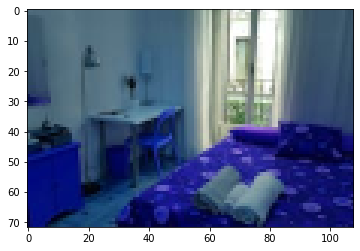

In [ ]:
plt.imshow(I_train[32])

Convertimos los dataset numericos y categoricos en objetos de tensorflow

In [ ]:
train_labels = tf.convert_to_tensor(train_labels)
train_features = tf.convert_to_tensor(train_features)
X_train = tf.convert_to_tensor (X_train)
X_val = tf.convert_to_tensor (X_val)
y_train = tf.convert_to_tensor (y_train)
y_val = tf.convert_to_tensor (y_val)

In [ ]:
train_images = tf.convert_to_tensor(images[df_train.index.tolist()])
test_images = tf.convert_to_tensor(images[df_test.index.tolist()])
I_train = tf.convert_to_tensor (I_train)
I_val = tf.convert_to_tensor (I_val)

Hacemos lo propio con el df_test

In [ ]:
y_test_max = df_test["Price"].max()

In [ ]:
scaler = preprocessing.StandardScaler().fit(df_test.copy(True).drop(columns="Price"))
test_features = scaler.transform(np.array(df_test.copy(True).drop(columns="Price")))
test_features = tf.convert_to_tensor(test_features)
test_labels = tf.convert_to_tensor(np.array(df_test.copy(True).pop('Price'))/y_test_max)

# **2 - Primer modelo**

# 2.1- Red MLP

In [ ]:
shape = X_train.shape[1]

Creamos el modelo

In [ ]:
def create_mlp():
# define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=shape, activation="relu"))
    model.add(Dense(4, activation="relu"))
# check to see if the regression node should be added
    #if regress: 
    model.add(Dense(1, activation="linear"))
    #Compile model 
    opt = keras.optimizers.Adam(learning_rate = 0.001)    
    model.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer=opt)
# return our model
    return model

In [ ]:
mlp_1 = create_mlp()
history = mlp_1.fit(x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=10,
    workers = -1, use_multiprocessing= True)

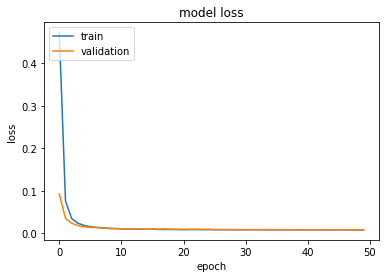

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("MSE test: %.4f " % history.history['val_mean_squared_error'][-1])
print("MSE train: %.4f " % history.history['mean_squared_error'][-1])

MSE test: 0.0084 
MSE train: 0.0084 


Nuestro modelo parece desempeñar bastante bien, sin embargo presenta cierto bias. Vamos a aumentar la complejidad del sistema a ver si podemos reducir el error en trainning y asi mejorar el de validación.

In [ ]:
def create_mlp_2():
# define our MLP network
    model = Sequential()
    model.add(Dense(16, input_dim=shape, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
# check to see if the regression node should be added
    #if regress: 
    model.add(Dense(1, activation="linear"))
    #Compile model 
    opt = keras.optimizers.Adam(learning_rate = 0.001) 
    model.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer=opt)
# return our model
    return model

In [ ]:
mlp_2 = create_mlp_2()
history_2 = mlp_2.fit(x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=20, batch_size=10,
    workers = -1, use_multiprocessing= True)

Epoch 1/20
670/670 [==============================] - 3s 2ms/step - loss: 0.1172 - mean_squared_error: 0.1172 - mean_absolute_percentage_error: 97.0949 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_percentage_error: 44.5641
Epoch 2/20
670/670 [==============================] - 1s 2ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_percentage_error: 42.1458 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_percentage_error: 37.3000
Epoch 3/20
670/670 [==============================] - 1s 2ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 35.8268 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_percentage_error: 30.3689
Epoch 4/20
670/670 [==============================] - 1s 2ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_percentage_error: 30.9520 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_percentage_error: 32.5541


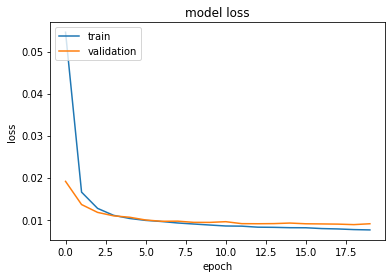

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("MSE test: %.4f " % history_2.history['val_mean_squared_error'][-1])
print("MSE train: %.4f " % history_2.history['mean_squared_error'][-1])

MSE test: 0.0090 
MSE train: 0.0076 


Hemos conseguido disminuir aun más el error de trainning pero el de test aumenta. Vamos a aumentar aun más la complejidad del modelo.

In [ ]:
def create_mlp_3():
# define our MLP network
    model = Sequential()
    model.add(Dense(32, input_dim=shape, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
# check to see if the regression node should be added
    #if regress: 
    model.add(Dense(1, activation="linear"))
    #Compile model 
    opt = keras.optimizers.Adam(learning_rate = 0.005)  
    model.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer=opt)
# return our model
    return model

In [ ]:
mlp_3 = create_mlp_3()
history_3 = mlp_3.fit(x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=10,
    workers = -1, use_multiprocessing= True)

Epoch 1/30
670/670 [==============================] - 2s 2ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - mean_absolute_percentage_error: 46.5026 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_percentage_error: 32.8664
Epoch 2/30
670/670 [==============================] - 1s 2ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_percentage_error: 31.0617 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_percentage_error: 40.7093
Epoch 3/30
670/670 [==============================] - 1s 2ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_percentage_error: 31.5888 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_percentage_error: 26.3923
Epoch 4/30
670/670 [==============================] - 1s 2ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_percentage_error: 27.9404 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_percentage_error: 31.9725


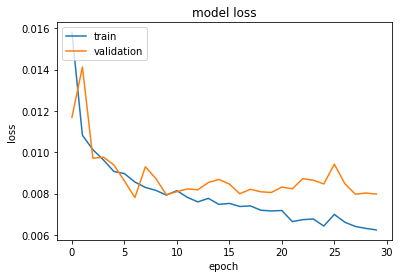

In [ ]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("MSE test: %.4f " % history_3.history['val_mean_squared_error'][-1])
print("MSE train: %.4f " % history_3.history['mean_squared_error'][-1])

MSE test: 0.0080 
MSE train: 0.0062 


El modelo parece desempeñar aun mejor en train pero no en test. Incluimos regularización para ver si esto lo hace mejorar.

In [ ]:
def create_mlp_4():
# define our MLP network
    model = Sequential()
    model.add(Dense(32, input_dim=shape, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation="relu"))
# check to see if the regression node should be added
    #if regress: 
    model.add(Dense(1, activation="linear"))
    #Compile model 
    opt = keras.optimizers.Adam(learning_rate = 0.005)  
    model.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer=opt)
# return our model
    return model

In [ ]:
mlp_4 = create_mlp_4()
history_4 = mlp_4.fit(x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=10,
    workers = -1, use_multiprocessing= True)

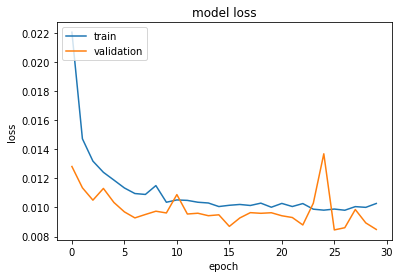

In [ ]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("MSE test: %.4f " % history_4.history['val_mean_squared_error'][-1])
print("MSE train: %.4f " % history_4.history['mean_squared_error'][-1])

MSE test: 0.0085 
MSE train: 0.0103 


El modelo ha empeorado, Vamos a hacer crossvalidation en el modelo mlp_1 y el modelo mlp_3 a ver cual es el que mejor desempeña.

In [ ]:
estimator = KerasRegressor(build_fn=create_mlp, epochs=20, batch_size=10, verbose=2, 
                           workers = -1, use_multiprocessing= True)
kfold = KFold(n_splits=5, shuffle=True, random_state = 123)
results = cross_validate(estimator,  train_features.numpy(), train_labels.numpy(), 
                         scoring = ['neg_mean_absolute_percentage_error', 'neg_mean_squared_error', "r2"],
                         cv=kfold, n_jobs=4, return_train_score = True)



In [ ]:
print("Percentage Test error: %.2f (%.2f) " % (results['test_neg_mean_absolute_percentage_error'].mean(),
                                       results['test_neg_mean_absolute_percentage_error'].std()))
print("Percentage Trainning error: %.2f (%.2f) " % (results['train_neg_mean_absolute_percentage_error'].mean(), 
                                        results['train_neg_mean_absolute_percentage_error'].std()))
print("MSE Test error: %.4f (%.4f) MSE" % (results['test_neg_mean_squared_error'].mean(), 
                                       results['test_neg_mean_squared_error'].std()))
print("MSE Trainning error: %.4f (%.4f) MSE" % (results['train_neg_mean_squared_error'].mean(),
                                            results['train_neg_mean_squared_error'].std()))
print("R2 Test error: %.4f (%.4f) in r" % (results['test_r2'].mean(), 
                                       results['test_r2'].std()))
print("R2 Trainning error: %.4f (%.4f) r" % (results['train_r2'].mean(),
                                            results['train_r2'].std()))

Percentage Test error: -0.29 (0.01) 
Percentage Trainning error: -0.28 (0.01) 
MSE Test error: -0.0099 (0.0005) MSE
MSE Trainning error: -0.0088 (0.0001) MSE
R2 Test error: 0.6735 (0.0189) in r
R2 Trainning error: 0.7090 (0.0048) r


In [ ]:
estimator = KerasRegressor(build_fn=create_mlp_3, epochs=20, batch_size=10, verbose=2, 
                           workers = -1, use_multiprocessing= True)
kfold = KFold(n_splits=5, shuffle=True, random_state = 123)
results = cross_validate(estimator,  train_features.numpy(), train_labels.numpy(), 
                         scoring = ['neg_mean_absolute_percentage_error', 'neg_mean_squared_error', "r2"],
                         cv=kfold, n_jobs=4, return_train_score = True)



In [ ]:
print("Percentage Test error: %.2f (%.2f) " % (results['test_neg_mean_absolute_percentage_error'].mean(),
                                       results['test_neg_mean_absolute_percentage_error'].std()))
print("Percentage Trainning error: %.2f (%.2f) " % (results['train_neg_mean_absolute_percentage_error'].mean(), 
                                        results['train_neg_mean_absolute_percentage_error'].std()))
print("MSE Test error: %.4f (%.4f) MSE" % (results['test_neg_mean_squared_error'].mean(), 
                                       results['test_neg_mean_squared_error'].std()))
print("MSE Trainning error: %.4f (%.4f) MSE" % (results['train_neg_mean_squared_error'].mean(),
                                            results['train_neg_mean_squared_error'].std()))
print("R2 Test error: %.4f (%.4f) in r" % (results['test_r2'].mean(), 
                                       results['test_r2'].std()))
print("R2 Trainning error: %.4f (%.4f) r" % (results['train_r2'].mean(),
                                            results['train_r2'].std()))

Percentage Test error: -0.26 (0.02) 
Percentage Trainning error: -0.24 (0.02) 
MSE Test error: -0.0090 (0.0004) MSE
MSE Trainning error: -0.0062 (0.0003) MSE
R2 Test error: 0.7035 (0.0120) in r
R2 Trainning error: 0.7940 (0.0089) r


El modelo mlp_3 es el que da mejores resultados y el que utilizaremos para nuestro modelo conjunto.

Una vez velegido el modelo mlp, creamos una version que pueda ser luego concatenada

In [ ]:
def create_mlp_def():
  # define our MLP network
    model = Sequential()
    model.add(Dense(32, input_dim=shape, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
# check to see if the regression node should be added
    #if regress: 
    #model.add(Dense(1, activation="linear"))
    #Compile model 
    #opt = keras.optimizers.Adam(learning_rate = 0.005)  
    #model.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer=opt)
# return our model
    return model


In [ ]:
mlp_def = create_mlp_def()

# 2.2 - Red CNN

Creamos una primera red sencilla

In [ ]:
input_shape = (I_train.shape[1],I_train.shape[2],I_train.shape[3])

In [ ]:
def create_cnn():
# initialize the input shape and channel dimension, assuming
# TensorFlow/channels-last ordering
    inputs = input_shape
    model = Sequential()
    model.add(Conv2D(6, kernel_size=5, activation='relu', input_shape=inputs))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear") )
    opt = keras.optimizers.Adam(learning_rate = 0.05)
    model.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer=opt)
  # return the CNN
    return model

In [ ]:
cnn_1 = create_cnn()
history_cnn_1 = cnn_1.fit(x=I_train, y=y_train,
    validation_data=(I_val, y_val),
    epochs=20, batch_size=50, steps_per_epoch = 20,
    workers = -1, use_multiprocessing= True)

Epoch 1/20
20/20 [==============================] - 12s 517ms/step - loss: 503.7319 - mean_squared_error: 503.7319 - mean_absolute_percentage_error: 4427.2544 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_percentage_error: 81.3183
Epoch 2/20
20/20 [==============================] - 10s 499ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_percentage_error: 87.2223 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_percentage_error: 94.8219
Epoch 3/20
20/20 [==============================] - 10s 499ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_percentage_error: 97.8538 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_percentage_error: 94.0639
Epoch 4/20
20/20 [==============================] - 10s 500ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_percentage_error: 96.9102 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_percentage_error

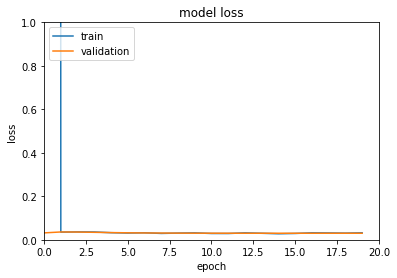

In [ ]:
plt.plot(history_cnn_1.history['loss'])
plt.plot(history_cnn_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0, 20, 0, 1])
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("MSE test: %.4f " % history_cnn_1.history['val_mean_squared_error'][-1])
print("MSE train: %.4f " % history_cnn_1.history['mean_squared_error'][-1])

MSE test: 0.0301 
MSE train: 0.0321 


Vamos a aumentar la complejidad del sistema añadiendo una red VG16.


In [ ]:
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

def create_cnn_2():
  base_model = VGG16(include_top=False,
      weights='imagenet',  # Load weights pre-trained on ImageNet.
      input_shape=input_shape)
  
  base_model.trainable = False
  inputs = keras.Input(shape=input_shape)
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.

  x = base_model(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(4, activation ="relu")(x)
  x = keras.layers.Dense(1, activation ="linear")(x)
  # A Dense classifier with a single unit (binary classification)
  outputs = keras.layers.Dense(1, activation='linear')(x)
  model = keras.Model(inputs, outputs)

  opt = keras.optimizers.Adam(learning_rate = 0.01)
  #model.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer="Adam")
  return model


In [ ]:
model = create_cnn_2()
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72, 108, 3)]      0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 3, 512)         14714688  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 2052      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
______________________________________________________________

In [ ]:
cnn_2 = create_cnn_2()
cnn_2.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer="Adam")
history_cnn_2 = cnn_2.fit(x=I_train, y=y_train,
    validation_data=(I_val, y_val),
    epochs=10, batch_size=50, steps_per_epoch = 20,
    workers = -1, use_multiprocessing= True)

Epoch 1/10
20/20 [==============================] - 229s 12s/step - loss: 0.3177 - mean_squared_error: 0.3177 - mean_absolute_percentage_error: 192.3779 - val_loss: 0.0553 - val_mean_squared_error: 0.0553 - val_mean_absolute_percentage_error: 126.3943
Epoch 2/10
20/20 [==============================] - 222s 11s/step - loss: 0.0463 - mean_squared_error: 0.0463 - mean_absolute_percentage_error: 112.0110 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_percentage_error: 70.8488
Epoch 3/10
20/20 [==============================] - 223s 12s/step - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_percentage_error: 67.4214 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_percentage_error: 61.9454
Epoch 4/10
20/20 [==============================] - 221s 11s/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_percentage_error: 67.1137 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_percentage_error: 64.91

In [ ]:
plt.plot(history_cnn_2.history['loss'])
plt.plot(history_cnn_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0, 20, 0, 0.2])
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("MSE test: %.4f " % history_cnn_2.history['val_mean_squared_error'][-1])
print("MSE train: %.4f " % history_cnn_2.history['mean_squared_error'][-1])

MSE test: 0.0274 
MSE train: 0.0299 


In [ ]:
def create_cnn_def():
  base_model = VGG16(include_top=False,
      weights='imagenet',  # Load weights pre-trained on ImageNet.
      input_shape=input_shape)
  
  base_model.trainable = False
  inputs = keras.Input(shape=input_shape)
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.

  x = base_model(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(4, activation ="relu")(x)

  # A Dense classifier with a single unit (binary classification)
 
  model = keras.Model(inputs, outputs)

  #opt = keras.optimizers.Adam(learning_rate = 0.01)
  #model.compile(loss="mean_squared_error", metrics = ["mean_squared_error", "mean_absolute_percentage_error"], optimizer="Adam")
  return model


In [ ]:
cnn_def = create_cnn_def()

# 2.3 - Union de ambas redes

Unimos el modelo MLP con el modelo CNN


In [ ]:
combinedInput = concatenate([mlp_def.output, cnn_def.output])

Añadimos unas últimas capas incluida una lineal para hacer regresión

In [ ]:
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

In [ ]:
model_1 = Model(inputs=[mlp_def.input, cnn_def.input], outputs=x)

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.005) 

In [ ]:
model_1.compile(loss="mean_squared_error", optimizer=opt)

In [ ]:
history_join = model_1.fit(x=[X_train, I_train], y=y_train,
    validation_data=([X_val, I_val], y_val),
    epochs=10, batch_size=30, steps_per_epoch = 20,
    workers = 4, use_multiprocessing= True)

Epoch 1/10
20/20 [==============================] - 189s 10s/step - loss: 0.0172 - val_loss: 0.0129
Epoch 2/10
20/20 [==============================] - 187s 10s/step - loss: 0.0120 - val_loss: 0.0116
Epoch 3/10
20/20 [==============================] - 185s 10s/step - loss: 0.0140 - val_loss: 0.0111
Epoch 4/10
20/20 [==============================] - 185s 10s/step - loss: 0.0119 - val_loss: 0.0105
Epoch 5/10
20/20 [==============================] - 186s 10s/step - loss: 0.0122 - val_loss: 0.0116
Epoch 6/10
20/20 [==============================] - 188s 10s/step - loss: 0.0121 - val_loss: 0.0107
Epoch 7/10
20/20 [==============================] - 186s 10s/step - loss: 0.0115 - val_loss: 0.0108
Epoch 8/10
20/20 [==============================] - 186s 10s/step - loss: 0.0092 - val_loss: 0.0107
Epoch 9/10
20/20 [==============================] - 186s 10s/step - loss: 0.0100 - val_loss: 0.0100
Epoch 10/10
20/20 [==============================] - 186s 10s/step - loss: 0.0100 - val_loss: 0.0103

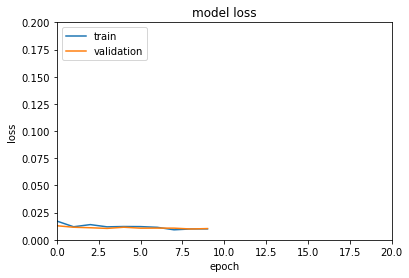

In [ ]:
plt.plot(history_join.history['loss'])
plt.plot(history_join.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0, 20, 0, 0.2])
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("MSE test: %.4f " % history_join.history['val_loss'][-1])
print("MSE train: %.4f " % history_join.history['loss'][-1])

MSE test: 0.0103 
MSE train: 0.0100 


Valoramos la performance de nuestro modelo final entrenado para predecir la parte de test

In [ ]:
y_hat = model_1.predict([test_features, images[df_test.index.tolist()]])

In [ ]:
y_hat = y_hat * y_test_max
y_test = test_labels.numpy() * y_test_max

Text(0, 0.5, 'Real_price')

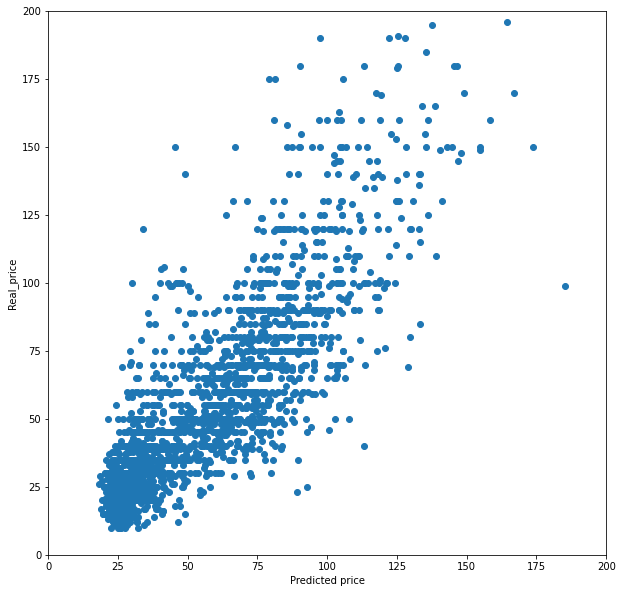

In [ ]:
plt.figure(figsize=(10, 10))  
plt.scatter(y_hat,y_test)
plt.axis([0, 200, 0, 200])
plt.xlabel('Predicted price')
plt.ylabel('Real_price')

In [ ]:
print("R2 score es {}".format(r2_score(y_test, y_hat)))
print("MSE score es {}".format(mean_squared_error(y_test, y_hat)))

R2 score es 0.6844424130861346
MSE score es 372.40692633375454
